<a href="https://colab.research.google.com/github/LargeMan/CAP4630/blob/master/HW_3/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Create and display random data

In [0]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D

In [0]:
def get_random_data(w, b, mu, sigma, m):
  data = np.empty((m, 2))
  label = np.empty((m, 1))
  for i in range(m):
    c = np.random.randint(2)
    x = np.random.random()
    n = np.random.normal(mu, sigma)
    y = w * x + b + (-1)**c * n
    data[i][0] = x
    data[i][1] = y
    label[i] = c

  return (data, label)



In [0]:
def display_random_data(data, label, x=None, y=0, w=0, b=0):
  fig, ax = plt.subplots()
  ax.axis([0,1, np.amin(data)-5, np.amax(data)+5])
  fig.canvas.draw()
  for i in range(label.size):
    if label[i]:
      clr = "red"
    else:
      clr = "blue"
    ax.scatter(data[i][0], data[i][1], color=clr)
  # Plot prediction lines when relevant arguments are given
  if x is not None:
    ax.plot(x, y, lw = 3.5, c = 'purple', label='Predicted')
    ax.plot(x, (w*x + b), lw = 3.5, c ='black', label='Actual')
    ax.legend()

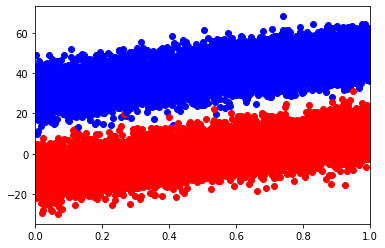

In [91]:
data, labels = get_random_data(20, 10, 20, 6, 20000)
display_random_data(data, labels)

In [0]:
def display_heat_map(X_min, X_max, Y_min, Y_max, func, weights, keras=False):
  x = np.linspace(X_min, X_max, 100)
  y = np.linspace(Y_min, Y_max, 100)
  X, Y = np.meshgrid(x,y)
  
  if not keras:
    Z = func(np.column_stack((X.flatten(), Y.flatten())), weights)
  else:
    Z = func(np.column_stack((X.flatten(), Y.flatten())))
  Z = Z.reshape((100,100))

  fig = plt.figure()
  ax = plt.axes()
  ax.contourf(X, Y, Z, 100, cmap='RdBu_r')
  im = ax.imshow(
    Z,
    extent=[X_min, X_max, Y_min, Y_max],
    origin='lower',
    cmap='RdBu_r',
    aspect = 'auto')
  
  plt.colorbar(im, ax=ax)




# Split the data/labels into a testing set and a training set

In [0]:
split_num = int(.8 * labels.size)
train_data = data[:split_num]
train_lbls = labels[:split_num]

test_data = data[split_num:]
test_lbls = labels[split_num:]

# Problem 2: Using keras/tensorflow to train a logistic regression model based on the random data from earlier

In [0]:
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.regularizers import L1L2

In [29]:
# For a single-input model with 2 classes (binary classification):

model = Sequential()
#model.add(Dense(32, activation='relu', input_dim=2))
model.add(Dense(1, activation='sigmoid', input_shape=(2,)))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model, iterating on the data in batches of 512 samples
model.fit(data, labels, epochs=250, batch_size=512,
          validation_data=(test_data, test_lbls))
weights = model.get_weights()
# The weights will return [np.array([w1,w2]), np.array[b]]
#display_random_data(data, labels, weights)

Epoch 1/250
40/40 [==============================] - 0s 5ms/step - loss: 3.9330 - accuracy: 0.2456 - val_loss: 3.4965 - val_accuracy: 0.2477
Epoch 2/250
40/40 [==============================] - 1s 32ms/step - loss: 3.0751 - accuracy: 0.2333 - val_loss: 2.6482 - val_accuracy: 0.2298
Epoch 3/250
40/40 [==============================] - 0s 2ms/step - loss: 2.2412 - accuracy: 0.2102 - val_loss: 1.8509 - val_accuracy: 0.1945
Epoch 4/250
40/40 [==============================] - 0s 2ms/step - loss: 1.4845 - accuracy: 0.1529 - val_loss: 1.1573 - val_accuracy: 0.0955
Epoch 5/250
40/40 [==============================] - 0s 2ms/step - loss: 0.9111 - accuracy: 0.0938 - val_loss: 0.7084 - val_accuracy: 0.4978
Epoch 6/250
40/40 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.5511 - val_loss: 0.5129 - val_accuracy: 0.6357
Epoch 7/250
40/40 [==============================] - 0s 2ms/step - loss: 0.4718 - accuracy: 0.6743 - val_loss: 0.4420 - val_accuracy: 0.7010
Epoch 8/250


[array([[ 8.265796 ],
       [-0.5317042]], dtype=float32), array([6.5419617], dtype=float32)]


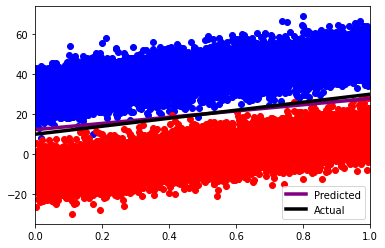

In [30]:
xt = np.linspace(0,1,100)
w1 = weights[0][0][0]
w2 = weights[0][1][0]
b = weights[1][0]
print(weights)
py = (-w1/w2)*xt + (-b/w2)
display_random_data(data, labels, x=xt, y=py, w=20, b=10)

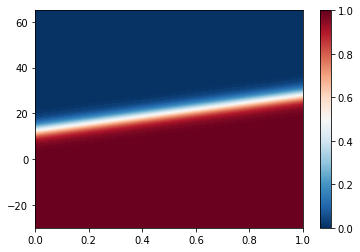

In [173]:
display_heat_map(0, 1, -30, 65, model.predict, weights, keras=True)

# Part 3: The pain


Logistic regression predicts $\hat{y}=b + w_1 x_1 + w_2 x_2$. It will be convenient to rewrite this as a dot product.  Define $w=(w_0, w_1, w_2)$ and $x=(1, x_1, x_2)$.  Then, we have $\hat{y}=w \boldsymbol{\cdot} x$.
<br/>

We can then plug this into the Sigmoid activation function


In [0]:
# Restacks data and adds w0 (aka b) as 1
def _data_preprocess(train_data, train_labels, test_data, test_labels):
  try:
    tmp = np.array(train_data)
    trn_l = np.array(train_labels)
  except:
    print("Invalid train_data or train_label dataset")
    return None, None, None, None

  trn_d = np.column_stack((np.ones((tmp.shape[0], 1)), tmp))

  try:
    tmp = np.array(test_data)
    tst_l = np.array(test_labels)
  except:
    print("Invalid test_data or test_label dataset")
    return None, None, None, None

  tst_d = np.column_stack((np.ones((tmp.shape[0], 1)), tmp))


  return trn_d, trn_l, tst_d, tst_l


# Trains weights given a dataset
def logistic_regression(train_data, train_labels, test_data, test_labels,
                        epochs = 100, rate=0.1):

  # Process data into a workable format, and adds an extra column for bias
  trn_d, trn_l, tst_d, tst_l = _data_preprocess(train_data, train_labels,
                                                test_data, test_labels)
  # Error handling
  if trn_d is None or tst_d is None:
    print("Modeling terminated")
    return None

  # Initialize weights (num of features + bias)
  weights = np.zeros((trn_d.shape[1], 1))

  # Runs a number of epochs
  for epoch in range(epochs):
    m = trn_d.shape[0]

    # Train each weight
    for data, label in zip(trn_d, trn_l):
      # Calculate summation of weights times features (like linear regression),
      # then throw this into Sigmoid activation func (thus making it logistic)
      z = data.dot(weights)
      a_sig = 1 / (1 + np.exp(-z))

      # Calculate the gradient
      gradient = (1/m) * np.array([(a_sig - label) * data]).T
      weights -= (gradient * rate)


    # Calculate loss and accuracy after every epoch
    # NOTE: This only works for binary classification

    z = tst_d.dot(weights)
    a_sig = 1 / (1 + np.exp(-z))
    tsize = tst_l.shape[0]

    # Binary Cross-Entropy Loss calculation
    loss = ((-tst_l* np.log(a_sig) - ((1-tst_l)* np.log(1-a_sig)))).sum()
    loss *= (1/tsize)

    # Accuracy calculation
    accuracy = 0
    for predict, actual in zip(a_sig, tst_l):
      predicted = np.rint(predict)
      if predicted == actual:
        accuracy += (1/tsize)

    print("Epoch {}/{}: Loss {:1.5f}, Accuracy {:1.5f}".format(epoch+1, epochs,
                                                               loss, accuracy))
  print()
  return weights

def predict(data, weights):
  newdata = np.column_stack((np.ones((data.shape[0], 1)), data))
  z = newdata.dot(weights)
  a_sig = 1 / (1 + np.exp(-z))
  return a_sig

Epoch 1/250: Loss 0.39661, Accuracy 0.74925
Epoch 2/250: Loss 0.38970, Accuracy 0.75450
Epoch 3/250: Loss 0.38295, Accuracy 0.76300
Epoch 4/250: Loss 0.37638, Accuracy 0.77075
Epoch 5/250: Loss 0.36999, Accuracy 0.77850
Epoch 6/250: Loss 0.36378, Accuracy 0.78600
Epoch 7/250: Loss 0.35774, Accuracy 0.79300
Epoch 8/250: Loss 0.35187, Accuracy 0.80025
Epoch 9/250: Loss 0.34617, Accuracy 0.80700
Epoch 10/250: Loss 0.34061, Accuracy 0.81375
Epoch 11/250: Loss 0.33521, Accuracy 0.81850
Epoch 12/250: Loss 0.32996, Accuracy 0.82175
Epoch 13/250: Loss 0.32484, Accuracy 0.82900
Epoch 14/250: Loss 0.31987, Accuracy 0.83225
Epoch 15/250: Loss 0.31502, Accuracy 0.83875
Epoch 16/250: Loss 0.31030, Accuracy 0.84375
Epoch 17/250: Loss 0.30571, Accuracy 0.84800
Epoch 18/250: Loss 0.30124, Accuracy 0.85600
Epoch 19/250: Loss 0.29688, Accuracy 0.85975
Epoch 20/250: Loss 0.29264, Accuracy 0.86225
Epoch 21/250: Loss 0.28850, Accuracy 0.86700
Epoch 22/250: Loss 0.28447, Accuracy 0.87200
Epoch 23/250: Loss 

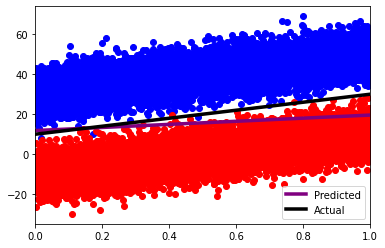

In [78]:
wghts = logistic_regression(train_data, train_lbls, test_data, test_lbls,
                            epochs = 250)
print("Weights in order:\n{}".format(wghts))
# Extracting the weights
w1 = wghts[1]
w2 = wghts[2]
b = wghts[0]
# Developing a relation between weights
py1 = (-w1/w2)*xt + (-b/w2)
display_random_data(data, labels, x=xt, y=py1, w=20, b=10)

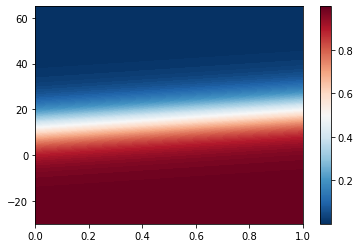

In [172]:
display_heat_map(0, 1, -30, 65, predict, wghts)